Images Data Type: <class 'numpy.uint8'> (5, 5, 5, 8, 4, 15, 64, 64, 3)
Labels Data Type: <class 'numpy.float64'> (5, 5, 5, 8, 4, 15, 6)
Images Mask Data Type: <class 'numpy.uint8'> (8, 4, 15, 64, 64, 3)
Labels Mask Data Type: <class 'numpy.float64'> (8, 4, 15, 1)


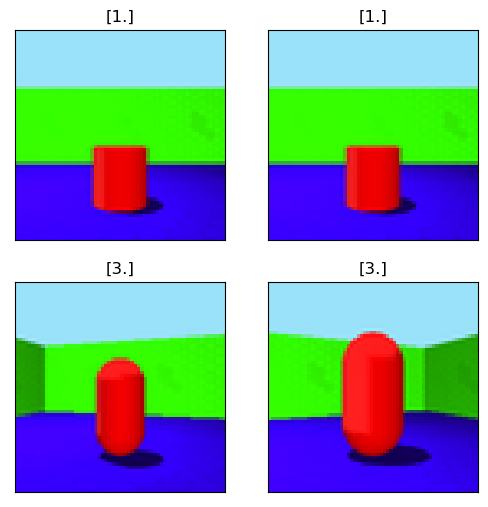

In [29]:
# Load python modules
import numpy as np, cv2, sys, h5py
from tqdm import tqdm
from matplotlib import pyplot as plt
np.set_printoptions(suppress=True)
# Load filtered image and label data sampled from 3dshapes_filtered.ipynb
images_mask = np.load("3DShapes/3dshapesfiltered.npy")
labels_mask = np.load("3DShapes/3dshapeslabel.npy")
# Load original 3dshapes dataset
dataset = h5py.File('3DShapes/3dshapes.h5', 'r')
images = dataset['images'][()]
images = images.reshape((10, 10, 10, 8, 4, 15, 64, 64, 3))
images = images[:5, :5, :5].reshape(5 * 5 * 5 * 8 * 4 * 15, 64, 64, 3)
labels = dataset['labels'][()]
labels = labels.reshape((10, 10, 10, 8, 4, 15, 6))
labels = labels[:5, :5, :5].reshape(5 * 5 * 5 * 8 * 4 * 15, 6) 
# Define visualisation function from https://github.com/google-deepmind/3d-shapes
def show_images_grid(images, labels, num_samples, num_images=25, random=False):
    ncols = int(np.ceil(num_images**0.5))
    nrows = int(np.ceil(num_images / ncols))
    _, axes = plt.subplots(ncols, nrows, figsize=(nrows*3, ncols*3))
    axes = axes.flatten()
    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
            if random:
                ax_i = np.random.choice(num_samples, 1)
                ax.imshow((images[int(ax_i[0])]/255.0).astype(np.float32), cmap='Greys_r', interpolation='nearest')
                ax.title.set_text(str(labels[ax_i]))
            else:
                ax.imshow((images[ax_i]/255.0).astype(np.float32), cmap='Greys_r', interpolation='nearest')
                ax.title.set_text(str(labels[ax_i]))
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')
# Sanity check loaded images
show_images_grid(images_mask, labels_mask, num_samples=480, num_images=4, random=True)
# Rework images into version better for factoring
images = images.reshape((5, 5, 5, 8, 4, 15, 64, 64, 3))
labels = labels.reshape((5, 5, 5, 8, 4, 15, 6))
images_mask = images_mask.reshape((8, 4, 15, 64, 64, 3))
labels_mask = labels_mask.reshape((8, 4, 15, 1))
# Sanity check datatype
print("Images Data Type:", type(images[0][0][0][0][0][0][0][0][0]), images.shape)
print("Labels Data Type:", type(labels[0][0][0][0][0][0][0]), labels.shape)
print("Images Mask Data Type:", type(images_mask[0][0][0][0][0][0]), images_mask.shape)
print("Labels Mask Data Type:", type(labels_mask[0][0][0][0]), labels_mask.shape)

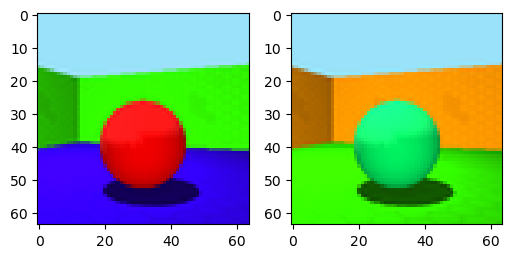

In [30]:
# Define comparison between mask image set and full image set
def comp_mask(image_mask, image_vanilla):
    _, axes = plt.subplots(1, 2, figsize=(1*6, 2*6))
    axes[0].imshow((image_mask/255.0).astype(np.float32), cmap='Greys_r', interpolation='nearest')
    axes[1].imshow((image_vanilla/255.0).astype(np.float32), cmap='Greys_r', interpolation='nearest')
# Sanity check
comp_mask(images_mask[5, 2, 12, :, :, :], images[3, 1, 4, 5, 2, 12, :, :, :])

Images Processed Set 0 Data Type: <class 'numpy.uint8'> (5, 5, 5, 8, 4, 15, 64, 64, 3)
Images Processed Set 0 Data Type: <class 'numpy.uint8'> (60000, 64, 64, 3)
Labels Processed Set 0 Type: <class 'numpy.float64'> (60000,)


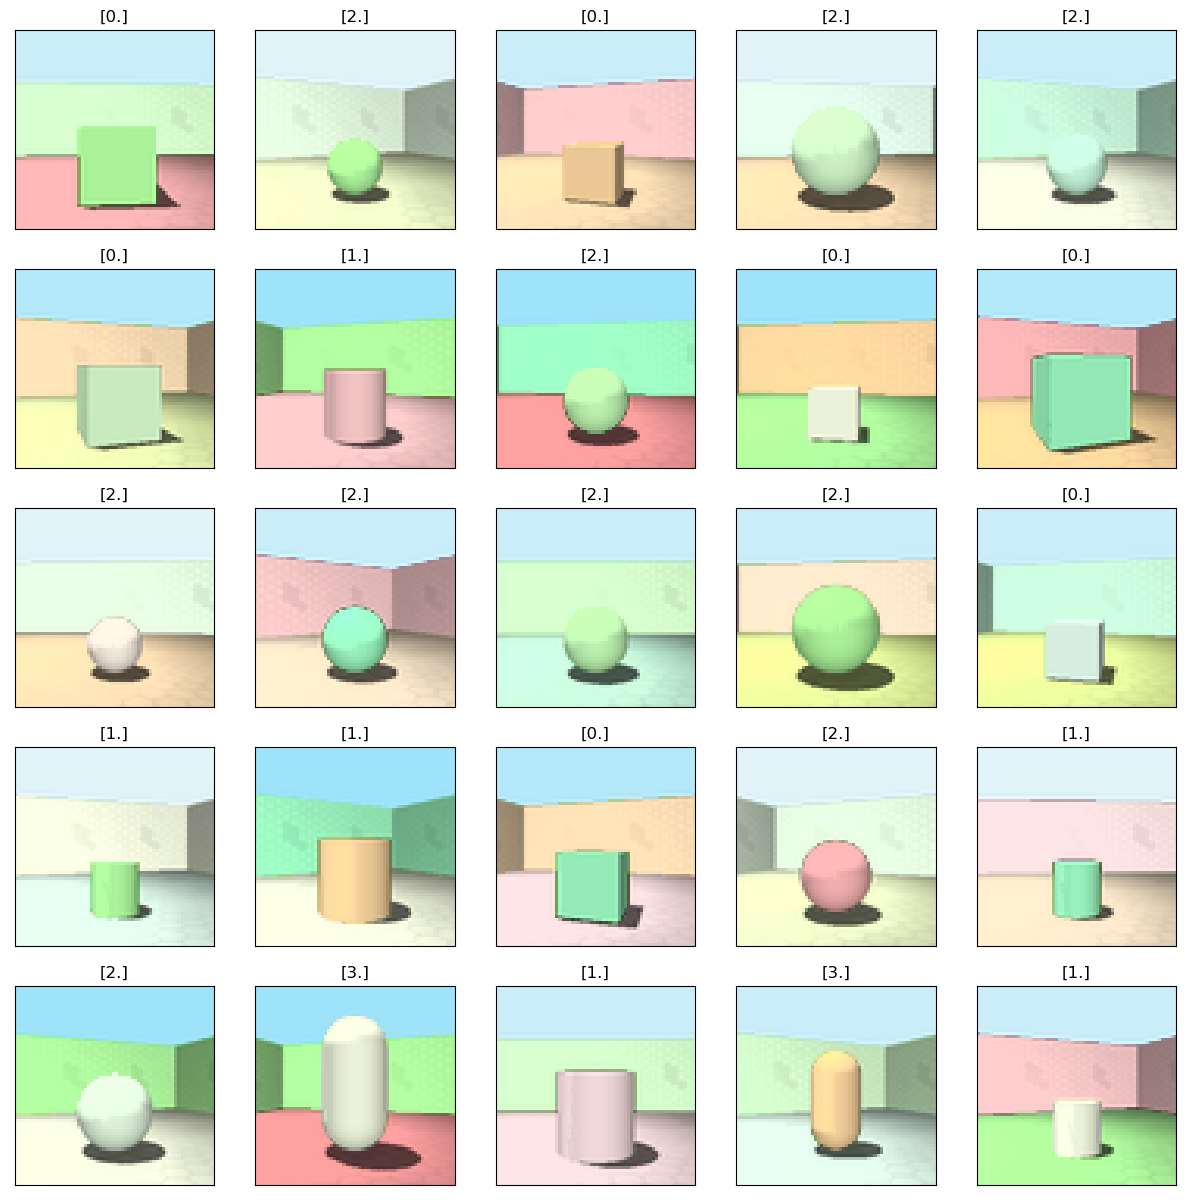

In [31]:
# Reset seed
np.random.seed(72)
# Set up new array
image_processed_0 = np.zeros_like(images, dtype=np.uint8)
# Set up distribution
uniform_lower = 0
uniform_upper = 4
# Loop over
for scale in range(8):
    for object in range(4):
        for orientation in range(15):
            # Load target masking image
            target_image_mask = images_mask[scale, object, orientation, :, :, :]
            # Convert image from RGB color space to BGR color space
            target_image_mask = cv2.cvtColor(target_image_mask, cv2.COLOR_RGB2BGR)
            # Convert image from BGR color space to HLS color space
            target_image_mask = cv2.cvtColor(target_image_mask, cv2.COLOR_BGR2HSV)
            # Create red mask on object
            mask_object_1 = cv2.inRange(target_image_mask, np.array([0/2, -1, -1]), np.array([60/2, 256, 256]))
            mask_object_2 = cv2.inRange(target_image_mask, np.array([291/2, -1, -1]), np.array([360/2, 256, 256]))
            # Create green mask on wall
            mask_wall = cv2.inRange(target_image_mask, np.array([61/2, -1, -1]), np.array([220/2, 256, 256]))
            # Create blue mask on floor
            mask_floor = cv2.inRange(target_image_mask, np.array([221/2, -1, -1]), np.array([290/2, 256, 256]))

            for wall_hue in range(5):
                for floor_hue in range(5):
                    for object_hue in range(5):
                        # Load target image
                        target_image = images[wall_hue, floor_hue, object_hue, scale, object, orientation, :, :, :]
                        # Convert image from RGB color space to BGR color space
                        target_image = cv2.cvtColor(target_image, cv2.COLOR_RGB2BGR)
                        # Convert image from BGR color space to HLS color space
                        target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2HSV)
                        # Split HSV representation into HSV channels
                        h, s, v = cv2.split(target_image)
                        # Change value of saturation channel for object
                        object_factor = np.random.randint(uniform_lower, uniform_upper, 1)
                        s[mask_object_1==255] = np.uint8((0.1 + (8.0/90.0)*object_factor)*255)
                        s[mask_object_2==255] = np.uint8((0.1 + (8.0/90.0)*object_factor)*255)
                        # Change value of saturation channel for wall
                        s[mask_wall==255] = np.uint8((0.1 + (8.0/90.0)*np.random.randint(uniform_lower, uniform_upper, 1))*255)
                        # Change value of saturation channel for floor
                        s[mask_floor==255] = np.uint8((0.1 + (8.0/90.0)*np.random.randint(uniform_lower, uniform_upper, 1))*255)
                        # Merge HSV back into target image
                        target_image = cv2.merge([h, s, v])
                        # Convert image from HLS color space to RGB color space
                        target_image = cv2.cvtColor(target_image, cv2.COLOR_HSV2BGR)
                        # Convert image from HLS color space to RGB color space
                        target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)
                        # Save saturation shifted image
                        image_processed_0[wall_hue, floor_hue, object_hue, scale, object, orientation, :, :, :] = target_image
# Sanity check datatype
print("Images Processed Set 0 Data Type:", type(image_processed_0[0][0][0][0][0][0][0][0][0]), image_processed_0.shape)
# Reshape images
image_processed_0 = image_processed_0.reshape(5*5*5*8*4*15, 64, 64, 3)
label_processed_0 = labels.reshape(5*5*5*8*4*15, 6)[:, 4]
# Sanity check loaded images
show_images_grid(image_processed_0, label_processed_0, num_samples=60000, num_images=25, random=True)
# Sanity check datatypes and dimenstions
print("Images Processed Set 0 Data Type:", type(image_processed_0[0][0][0][0]), image_processed_0.shape)
print("Labels Processed Set 0 Type:", type(label_processed_0[0]), label_processed_0.shape)
# Save data
np.savez("3DShapesSaturation/3dshapes_satshifted_0.npz", images=image_processed_0, labels=label_processed_0)

Images Processed Set 1 Data Type: <class 'numpy.uint8'> (5, 5, 5, 8, 4, 15, 64, 64, 3)
Images Processed Set 1 Data Type: <class 'numpy.uint8'> (60000, 64, 64, 3)
Labels Processed Set 1 Type: <class 'numpy.float64'> (60000,)


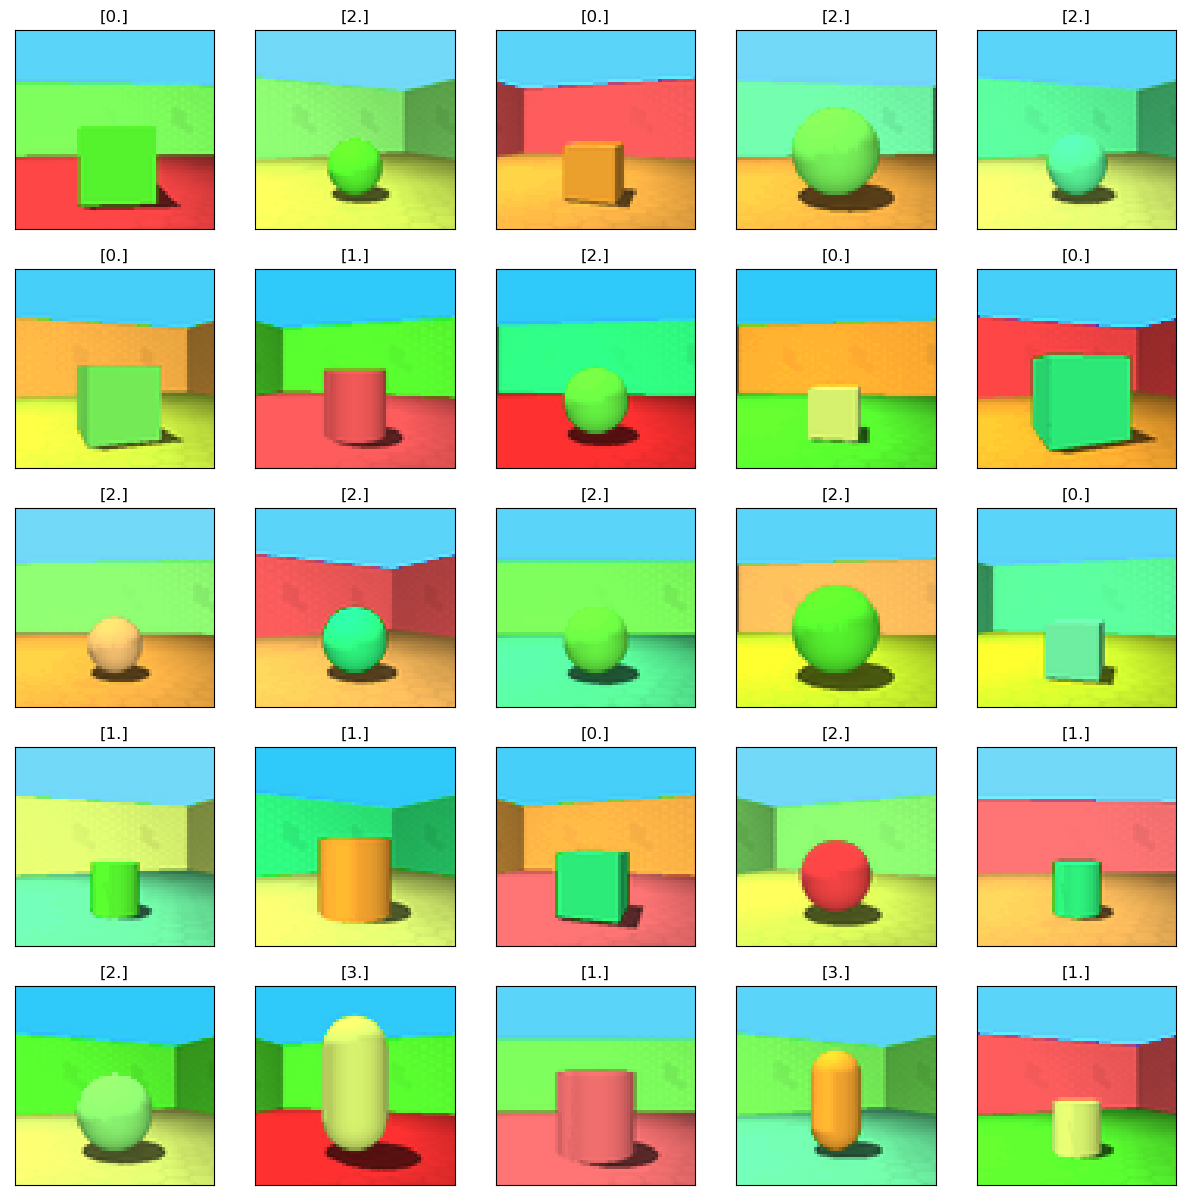

In [32]:
# Reset seed
np.random.seed(72)
# Set up new array
image_processed_1 = np.zeros_like(images, dtype=np.uint8)
# Set up distribution
uniform_lower = 5
uniform_upper = 9
# Loop over
for scale in range(8):
    for object in range(4):
        for orientation in range(15):
            # Load target masking image
            target_image_mask = images_mask[scale, object, orientation, :, :, :]
            # Convert image from RGB color space to BGR color space
            target_image_mask = cv2.cvtColor(target_image_mask, cv2.COLOR_RGB2BGR)
            # Convert image from BGR color space to HLS color space
            target_image_mask = cv2.cvtColor(target_image_mask, cv2.COLOR_BGR2HSV)
            # Create red mask on object
            mask_object_1 = cv2.inRange(target_image_mask, np.array([0/2, -1, -1]), np.array([60/2, 256, 256]))
            mask_object_2 = cv2.inRange(target_image_mask, np.array([291/2, -1, -1]), np.array([360/2, 256, 256]))
            # Create green mask on wall
            mask_wall = cv2.inRange(target_image_mask, np.array([61/2, -1, -1]), np.array([220/2, 256, 256]))
            # Create blue mask on floor
            mask_floor = cv2.inRange(target_image_mask, np.array([221/2, -1, -1]), np.array([290/2, 256, 256]))

            for wall_hue in range(5):
                for floor_hue in range(5):
                    for object_hue in range(5):
                        # Load target image
                        target_image = images[wall_hue, floor_hue, object_hue, scale, object, orientation, :, :, :]
                        # Convert image from RGB color space to BGR color space
                        target_image = cv2.cvtColor(target_image, cv2.COLOR_RGB2BGR)
                        # Convert image from BGR color space to HLS color space
                        target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2HSV)
                        # Split HSV representation into HSV channels
                        h, s, v = cv2.split(target_image)
                        # Change value of saturation channel for object
                        object_factor = np.random.randint(uniform_lower, uniform_upper, 1)
                        s[mask_object_1==255] = np.uint8((0.1 + (8.0/90.0)*object_factor)*255)
                        s[mask_object_2==255] = np.uint8((0.1 + (8.0/90.0)*object_factor)*255)
                        # Change value of saturation channel for wall
                        s[mask_wall==255] = np.uint8((0.1 + (8.0/90.0)*np.random.randint(uniform_lower, uniform_upper, 1))*255)
                        # Change value of saturation channel for floor
                        s[mask_floor==255] = np.uint8((0.1 + (8.0/90.0)*np.random.randint(uniform_lower, uniform_upper, 1))*255)
                        # Merge HSV back into target image
                        target_image = cv2.merge([h, s, v])
                        # Convert image from HLS color space to RGB color space
                        target_image = cv2.cvtColor(target_image, cv2.COLOR_HSV2BGR)
                        # Convert image from HLS color space to RGB color space
                        target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)
                        # Save saturation shifted image
                        image_processed_1[wall_hue, floor_hue, object_hue, scale, object, orientation, :, :, :] = target_image
# Sanity check datatype
print("Images Processed Set 1 Data Type:", type(image_processed_1[0][0][0][0][0][0][0][0][0]), image_processed_1.shape)
# Reshape images
image_processed_1 = image_processed_1.reshape(5*5*5*8*4*15, 64, 64, 3)
label_processed_1 = labels.reshape(5*5*5*8*4*15, 6)[:, 4]
# Sanity check loaded images
show_images_grid(image_processed_1, label_processed_1, num_samples=60000, num_images=25, random=True)
# Sanity check datatypes and dimenstions
print("Images Processed Set 1 Data Type:", type(image_processed_1[0][0][0][0]), image_processed_1.shape)
print("Labels Processed Set 1 Type:", type(label_processed_1[0]), label_processed_1.shape)
# Save data
np.savez("3DShapesSaturation/3dshapes_satshifted_1.npz", images=image_processed_1, labels=label_processed_1)

Images Processed Set 1 Data Type: <class 'numpy.uint8'> (5, 5, 5, 8, 4, 15, 64, 64, 3)
Images Processed Set 1 Data Type: <class 'numpy.uint8'> (60000, 64, 64, 3)
Labels Processed Set 1 Type: <class 'numpy.float64'> (60000,)


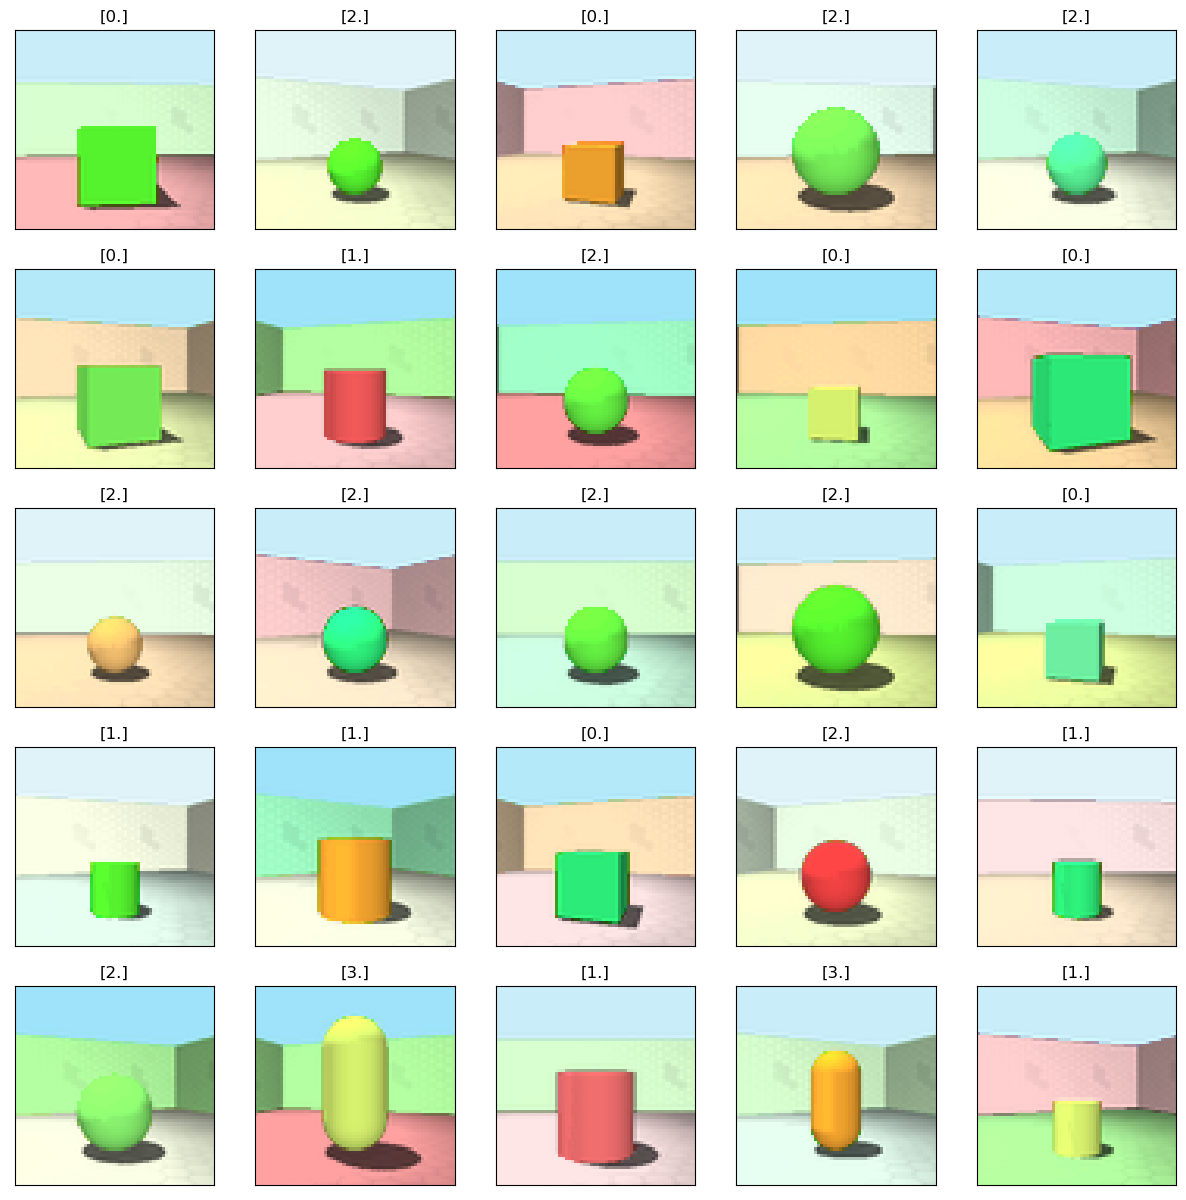

In [33]:
# Reset seed
np.random.seed(72)
# Set up new array
image_processed_2 = np.zeros_like(images, dtype=np.uint8)
# Set up distribution
uniform_lower = 0
uniform_upper = 4
# Loop over
for scale in range(8):
    for object in range(4):
        for orientation in range(15):
            # Load target masking image
            target_image_mask = images_mask[scale, object, orientation, :, :, :]
            # Convert image from RGB color space to BGR color space
            target_image_mask = cv2.cvtColor(target_image_mask, cv2.COLOR_RGB2BGR)
            # Convert image from BGR color space to HLS color space
            target_image_mask = cv2.cvtColor(target_image_mask, cv2.COLOR_BGR2HSV)
            # Create red mask on object
            mask_object_1 = cv2.inRange(target_image_mask, np.array([0/2, -1, -1]), np.array([60/2, 256, 256]))
            mask_object_2 = cv2.inRange(target_image_mask, np.array([291/2, -1, -1]), np.array([360/2, 256, 256]))
            # Create green mask on wall
            mask_wall = cv2.inRange(target_image_mask, np.array([61/2, -1, -1]), np.array([220/2, 256, 256]))
            # Create blue mask on floor
            mask_floor = cv2.inRange(target_image_mask, np.array([221/2, -1, -1]), np.array([290/2, 256, 256]))

            for wall_hue in range(5):
                for floor_hue in range(5):
                    for object_hue in range(5):
                        # Load target image
                        target_image = images[wall_hue, floor_hue, object_hue, scale, object, orientation, :, :, :]
                        # Convert image from RGB color space to BGR color space
                        target_image = cv2.cvtColor(target_image, cv2.COLOR_RGB2BGR)
                        # Convert image from BGR color space to HLS color space
                        target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2HSV)
                        # Split HSV representation into HSV channels
                        h, s, v = cv2.split(target_image)
                        # Change value of saturation channel for object
                        object_factor = np.random.randint(5, 9, 1)
                        s[mask_object_1==255] = np.uint8((0.1 + (8.0/90.0)*object_factor)*255)
                        s[mask_object_2==255] = np.uint8((0.1 + (8.0/90.0)*object_factor)*255)
                        # Change value of saturation channel for wall
                        s[mask_wall==255] = np.uint8((0.1 + (8.0/90.0)*np.random.randint(uniform_lower, uniform_upper, 1))*255)
                        # Change value of saturation channel for floor
                        s[mask_floor==255] = np.uint8((0.1 + (8.0/90.0)*np.random.randint(uniform_lower, uniform_upper, 1))*255)
                        # Merge HSV back into target image
                        target_image = cv2.merge([h, s, v])
                        # Convert image from HLS color space to RGB color space
                        target_image = cv2.cvtColor(target_image, cv2.COLOR_HSV2BGR)
                        # Convert image from HLS color space to RGB color space
                        target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)
                        # Save saturation shifted image
                        image_processed_2[wall_hue, floor_hue, object_hue, scale, object, orientation, :, :, :] = target_image
# Sanity check datatype
print("Images Processed Set 1 Data Type:", type(image_processed_2[0][0][0][0][0][0][0][0][0]), image_processed_2.shape)
# Reshape images
image_processed_2 = image_processed_2.reshape(5*5*5*8*4*15, 64, 64, 3)
label_processed_2 = labels.reshape(5*5*5*8*4*15, 6)[:, 4]
# Sanity check loaded images
show_images_grid(image_processed_2, label_processed_2, num_samples=60000, num_images=25, random=True)
# Sanity check datatypes and dimenstions
print("Images Processed Set 1 Data Type:", type(image_processed_2[0][0][0][0]), image_processed_2.shape)
print("Labels Processed Set 1 Type:", type(label_processed_2[0]), label_processed_2.shape)
# Save data
np.savez("3DShapesSaturation/3dshapes_satshifted_2.npz", images=image_processed_2, labels=label_processed_2)